In [1]:
import numpy as np 

import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()

import tensorflow_probability as tfp
# -- plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#import tensorflow as tf 
"""
Gumbel Softmax functions borrowed from http://blog.evjang.com/2016/11/tutorial-categorical-variational.html
"""

def sample_gumbel(shape, eps=1e-7): 
    """Sample from Gumbel(0, 1)"""
    U = tf.random_uniform(shape,minval=0,maxval=1)
    return -tf.log(-tf.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature): 
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(tf.shape(logits))
    return tf.nn.softmax( y / temperature)

def gumbel_softmax(logits, temperature, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
        Args:
        logits: [batch_size, n_class] unnormalized log-probs
        temperature: non-negative scalar
        hard: if True, take argmax, but differentiate w.r.t. soft sample y
        Returns:
        [batch_size,..., n_class] sample from the Gumbel-Softmax distribution.
        If hard=True, then the returned sample will be one-hot, otherwise it will
        be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        k = tf.shape(logits)[-1]
        #y_hard = tf.cast(tf.one_hot(tf.argmax(y,1),k), y.dtype)
        y_hard = tf.cast(tf.equal(y,tf.reduce_max(y,-1,keep_dims=True)),y.dtype)
        y = tf.stop_gradient(y_hard - y) + y
    return y

In [3]:
d = gumbel_softmax(np.array([np.log(0.5), np.log(0.5)] ), 0.5, hard=True)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [4]:
tfp.__version__

'0.8.0'

In [5]:
sess = tf.Session()

In [6]:
_Mmin = tf.get_variable(name='mass', initializer=13.2, dtype=tf.float32)

In [7]:
Mhalo = tf.convert_to_tensor(np.random.uniform(11., 14., 1000), dtype=tf.float32)
siglogm = tf.convert_to_tensor(0.2, dtype=tf.float32)
temperature = 0.5

def Ncen(Mmin): 
    # mean occupation of centrals
    return tf.clip_by_value(0.5 * (1+tf.math.erf((Mhalo - Mmin)/siglogm)),1e-4,1-1e-4)

def hod(Mmin): 
    p = Ncen(Mmin)
    samp = gumbel_softmax(tf.stack([tf.log(p), tf.log(1.-p)],axis=1), temperature, hard=True)
    return samp[...,0]


def numden(Mmin): 
    return tf.reduce_sum(hod(Mmin))

(11, 13.5)

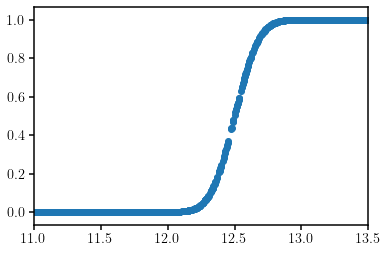

In [8]:
ncen,mh,nh = sess.run([Ncen(12.5), Mhalo, hod(12.5)] )
plt.scatter(mh, (ncen))
plt.xlim(11, 13.5)

(11.0, 13.5)

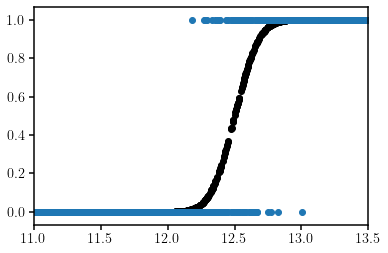

In [9]:
plt.scatter(mh, (ncen), c='k')
plt.scatter(mh, nh)
plt.xlim(11., 13.5)

In [10]:
Mmin_true = 12.5

In [11]:
loss = (numden(Mmin_true) - numden(_Mmin))**2

In [12]:
opt = tf.train.AdamOptimizer(learning_rate=0.01)

In [13]:
opt_op = opt.minimize(loss)

In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
losses=[]
masses=[]
for i in range(200):
    _,l,m = sess.run([opt_op, loss, _Mmin])
    losses.append(l)
    masses.append(m)

In [16]:
losses

[55225.0,
 49284.0,
 42436.0,
 41616.0,
 42025.0,
 36481.0,
 40000.0,
 42849.0,
 39601.0,
 37249.0,
 37636.0,
 30976.0,
 30976.0,
 32400.0,
 30276.0,
 30625.0,
 30976.0,
 29929.0,
 29929.0,
 29584.0,
 26244.0,
 29584.0,
 22201.0,
 20736.0,
 21609.0,
 19044.0,
 15876.0,
 23409.0,
 17689.0,
 15376.0,
 15876.0,
 15376.0,
 13924.0,
 15376.0,
 12100.0,
 12544.0,
 15876.0,
 13456.0,
 11881.0,
 10000.0,
 9801.0,
 8649.0,
 12321.0,
 9409.0,
 9025.0,
 8464.0,
 6889.0,
 9604.0,
 9216.0,
 7056.0,
 4624.0,
 9216.0,
 5625.0,
 6561.0,
 5184.0,
 5041.0,
 4624.0,
 3364.0,
 2601.0,
 3969.0,
 4489.0,
 4096.0,
 3481.0,
 4096.0,
 3136.0,
 2025.0,
 2500.0,
 1849.0,
 3364.0,
 2116.0,
 3136.0,
 1156.0,
 2500.0,
 1764.0,
 1600.0,
 1600.0,
 1600.0,
 1156.0,
 1521.0,
 1600.0,
 1369.0,
 1089.0,
 1225.0,
 729.0,
 484.0,
 961.0,
 1024.0,
 625.0,
 484.0,
 1156.0,
 961.0,
 1369.0,
 289.0,
 1024.0,
 1681.0,
 361.0,
 841.0,
 361.0,
 1024.0,
 841.0,
 121.0,
 441.0,
 225.0,
 49.0,
 100.0,
 324.0,
 256.0,
 49.0,
 289.0,


In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


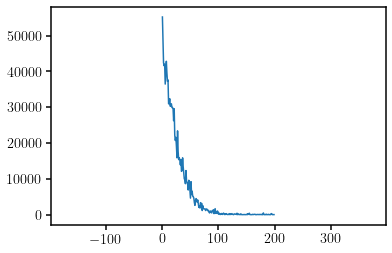

In [18]:
plot(losses)

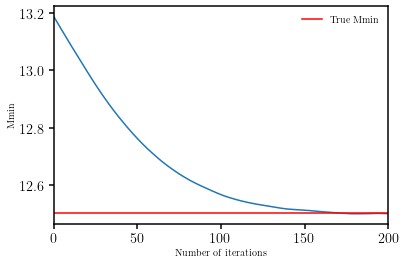

In [19]:
plot(masses)
axhline(Mmin_true, color='r', label='True Mmin')
xlim(0,200)
xlabel('Number of iterations')
ylabel('Mmin')
legend()